In [46]:
NORMAL_DRIVING_PATH = './data2/normal/'
CORRECTIN_DRIVING_PATH = './data2/correcting/'
REVERSE_DRIVING_PATH = './data2/reverse/'
normal_liens = []
correction_lines = []
reverse_lines = []

In [47]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


def get_lines(path):
    lines = []
    with open ('%sdriving_log.csv' % path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
        return lines


normal_lines = get_lines(NORMAL_DRIVING_PATH)
correction_lines = get_lines(CORRECTIN_DRIVING_PATH)
reverse_lines = get_lines(REVERSE_DRIVING_PATH)

all_lines = normal_lines + correction_lines + reverse_lines


In [48]:
# Let's look at the distribution of angles
def plot_histogram(labels, bins):
    history, bins = np.histogram(labels, bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, history, align='center', width=width)
    plt.show()

In [49]:
def get_soft_sharp_split(data, threshold=0.3):
    soft_turns = []
    sharp_turns = []
    for line in data:
        if abs(float(line[3])) >= threshold:
            sharp_turns.append(line)
        else:
            soft_turns.append(line)
    return soft_turns, sharp_turns

In [50]:
def analyze_dataset(lines):
    lines = np.asarray(lines)
    angles = lines[:,3].astype(np.float)
    min_angle = np.amin(angles)
    max_angle = np.amax(angles)
    bins = np.arange(min_angle, max_angle, step=0.005)

    plot_histogram(angles, bins)
    soft, sharp = get_soft_sharp_split(lines)
    print("Total examples: %d" % len(lines))
    print("Number of soft turns: %d" % len(soft))
    print("Number of sharp turns: %d" % len(sharp))

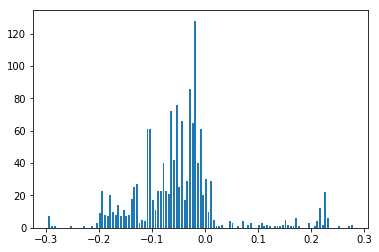

Total examples: 1424
Number of soft turns: 1424
Number of sharp turns: 0


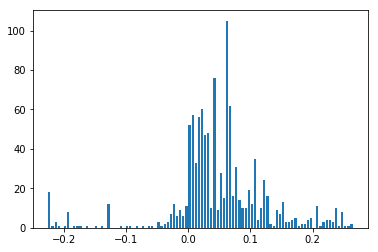

Total examples: 1092
Number of soft turns: 1092
Number of sharp turns: 0


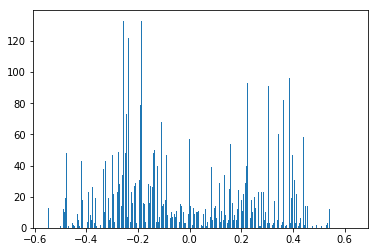

Total examples: 3574
Number of soft turns: 2486
Number of sharp turns: 1088


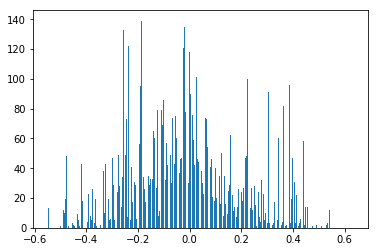

Total examples: 6090
Number of soft turns: 5002
Number of sharp turns: 1088


In [51]:
analyze_dataset(normal_lines)
analyze_dataset(reverse_lines)
analyze_dataset(correction_lines)
analyze_dataset(all_lines)

In [33]:
def load_image(img_full_path):
    # Name of the img, e.g. center_2017_10_24_17_22_37_747.jpg
    name = img_full_path.split('/')[-1]

    # Mode, i.e. normal, correcting, reverse
    dataset = img_full_path.split('/')[-3]

    path = './data2/%s/IMG/%s' % (dataset, name)
    #path = './samples-training/data/IMG/%s' % name
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

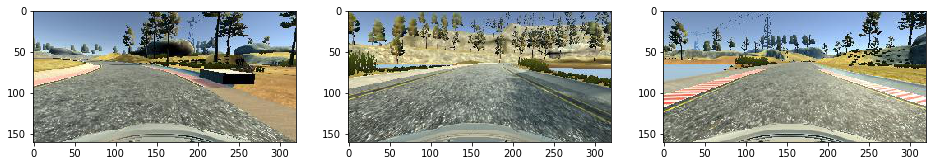

In [34]:
center_line, left_line, right_line = None, None, None
for line in all_lines:
    try:
        angle = float(line[3])
    except:
        print(line)
    if angle < -0.4:
        left_line = line
    elif angle > 0.4:
        right_line = line
    elif angle > -0.2 and angle < 0.2:
        center_line = line

#all_lines = [center_line, left_line, right_line]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))
ax = ax.ravel()

ax[0].imshow(load_image(left_line[0]))
ax[1].imshow(load_image(center_line[0]))
ax[2].imshow(load_image(right_line[0]))

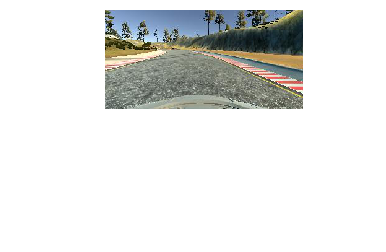

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(all_lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

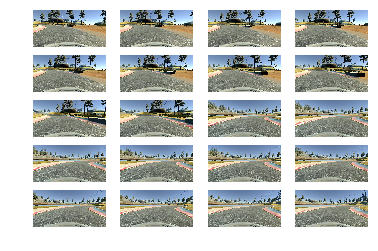

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(all_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4)

ax = ax.ravel()

right_count = 0
left_count = 0
left = []
right = []

for line in all_lines:
    angle = float(line[3])
    if angle > 0.2 and right_count < 10:
        right.append(load_image(line[0]))
        right_count += 1
    elif angle < -0.2 and left_count < 10:
        left.append(load_image(line[0]))
        left_count += 1

    

for i in range(0, 20):
    ax[i].imshow(left[i] if i < 10 else right[i-10])

for a in ax:
    a.axis('off')

In [14]:
import numpy as np
from skimage import transform

def random_translate(img, steering_angle, is_debug=False):
    random_x = np.random.randint(-50, 50)
    random_y = np.random.randint(-25, 25)
    steering_angle = steering_angle + random_x * 0.004
    tform = transform.SimilarityTransform(translation=(random_x, random_y))
    translated = transform.warp(img, tform)
    if is_debug:
        print('Random X: %s, Random Y: %s, Steering Angle Adjustment: %s' %(random_x, random_y, steering_angle))
    return translated, steering_angle

In [15]:
def random_brightness(img):
    img = np.array(img, dtype=np.uint8)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    brightness = .25 + np.random.uniform()
    hsv[:,:,2] = hsv[:,:,2] * brightness
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

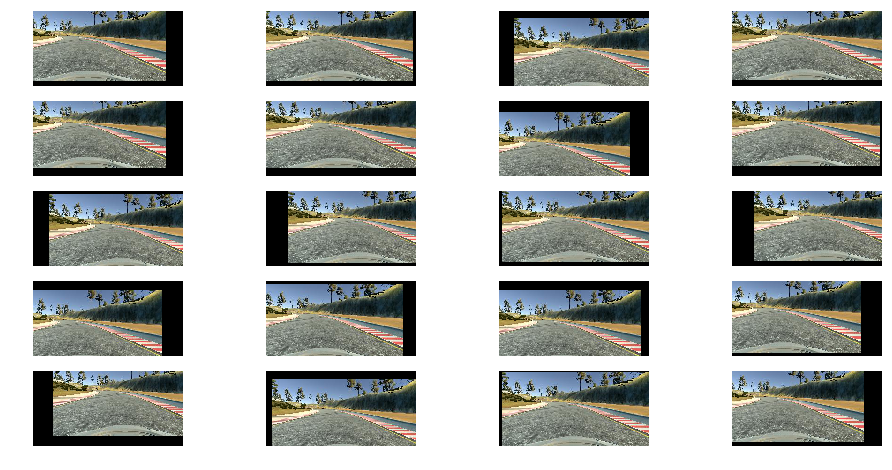

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(all_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 8))

ax = ax.ravel()

for i in range(0, 20):
    translated, _ = random_translate(sample_img, steering_angle)
    ax[i].imshow(translated)

for a in ax:
    a.axis('off')

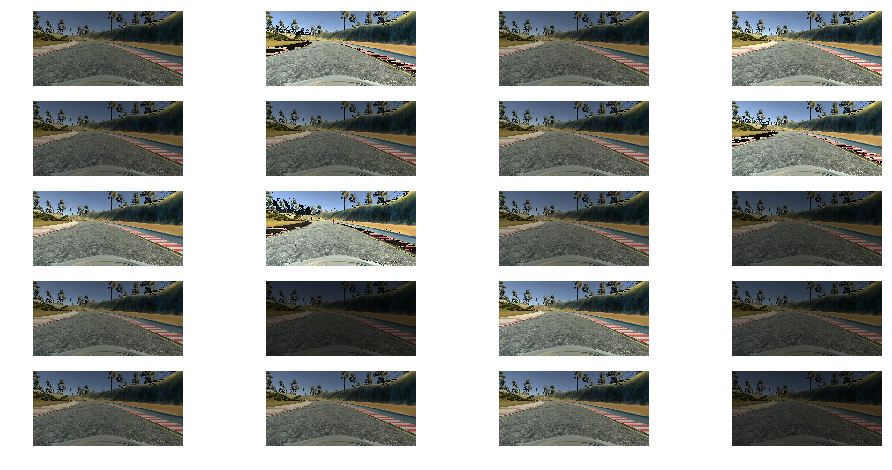

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(all_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4, figsize=(16, 8))

ax = ax.ravel()

for i in range(0, 20):
    bright = random_brightness(sample_img)
    ax[i].imshow(bright)

for a in ax:
    a.axis('off')

In [18]:
CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.25
RIGHT_ANGLE_CORRECTION = -0.25

def get_training_image(line, camera=None):
    camera = np.random.randint(CENTER, RIGHT + 1) if camera is None else camera
    camera_img = load_image(line[camera])
    angle = float(line[ANGLE])

    steering_correction = 0.0

    if camera is LEFT:
        steering_correction = LEFT_ANGLE_CORRECTION
    elif camera is RIGHT:
        steering_correction = RIGHT_ANGLE_CORRECTION

    return camera_img, angle + steering_correction
    

In [19]:
def drop_random_low_angles(data, keep_probability=0.6, threshold=0.2):
    new_data = []
    for line in data:
        angle = abs(float(line[ANGLE]))
        if angle < threshold:
            if np.random.uniform() < keep_probability:
                new_data.append(line)
        else:
            new_data.append(line)
    return new_data

In [20]:
CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.25
RIGHT_ANGLE_CORRECTION = -0.25

In [21]:
def make_validation_generator(data, batch_size=256):
    while True:
        num_samples = len(data)
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                img = load_image(batch_sample[CENTER])
                angle = float(batch_sample[ANGLE])
                images.append(img)
                angles.append(angle)
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield x_images, y_labels
                

In [22]:
import sklearn.utils

train_num_samples = 0

def make_train_generator(data, batch_size=256):
    while True:
        data = sklearn.utils.shuffle(data)
        num_samples = len(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:

                img, angle = get_training_image(batch_sample, camera=CENTER)
                
                images.append(img)
                angles.append(angle)
                
                #augmented_img = random_brightness(img)
                augmented_img, augmented_angle = random_translate(img, angle)

                # Maybe flip the image
                if np.random.randint(2):
                    augmented_img = np.fliplr(augmented_img)
                    augmented_angle *= -1

                images.append(augmented_img)
                angles.append(augmented_angle)

                left_camera, left_angle = get_training_image(batch_sample, camera=LEFT)
                right_camera, right_angle = get_training_image(batch_sample, camera=RIGHT)
                images.append(left_camera)
                images.append(right_camera)
                angles.append(left_angle)
                angles.append(right_angle)
                
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [52]:
from sklearn.model_selection import train_test_split

train_samples, validation_samples = train_test_split(all_lines, test_size=0.2)

print("Number of training examples before dropping low angles: %d" % len(train_samples))
train_samples = drop_random_low_angles(train_samples, keep_probability=0.5, threshold=0.3)
print("Number of training examples after randomly dropping low angles: %d\n" % len(train_samples))

soft, sharp = get_soft_sharp_split(train_samples, threshold=0.35)
print("Number of soft angles: %d" % len(soft))
print("Number of sharp angles: %d" % len(sharp))

# Add more sharp turns if needed
to_add = len(soft) - len(sharp)
print("Need to add %d additional sharp turns\n" % to_add)

# Add more sharp turns
for i in range(to_add):
    # Modulo so we can start from the beginning again
    sharp.append(sharp[i % len(sharp)])

train_samples = sklearn.utils.shuffle(sharp + soft)
train_num_samples = len(train_samples)


train_generator = make_train_generator(train_samples, batch_size=256)
validation_generator = make_validation_generator(validation_samples, batch_size=256)

print("Number of training examples: %d" % len(train_samples))
print("Number of validation examples: %d" % len(validation_samples))

Number of training examples before dropping low angles: 4872
Number of training examples after randomly dropping low angles: 2883

Number of soft angles: 2293
Number of sharp angles: 590
Need to add 1703 additional sharp turns

Number of training examples: 4586
Number of validation examples: 1218


In [44]:
def resize(img):
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

In [53]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape, Dropout
from keras.optimizers import Adam

model = Sequential()
# Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

# Resize the image to match the nvidia sizes.
model.add(Lambda(resize))

# Normalize the image.
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), name='conv1', activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), name='conv2', activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), name='conv3', activation='relu'))
model.add(Convolution2D(64, 3, 3, name='conv4', activation='relu'))
model.add(Convolution2D(64, 3, 3, name='conv5', activation='relu'))

model.add(Flatten())
#model.add(Dense(1, activation='elu'))

#model.summary()

model.add(Dropout(0.5))
model.add(Dense(1164, name='desn1164', activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, name='dense100'))
model.add(Dropout(0.5))
model.add(Dense(50, name='dense50'))
model.add(Dropout(0.5))
model.add(Dense(10, name='dense10'))
model.add(Dense(1, name='dense1'))

model.compile(loss='mse', optimizer=Adam(lr=0.001))
model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples) * 4,    # * 4 for center, left, and right image, augmented
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples),
    nb_epoch=5)

model.save('model.h5')

Epoch 1/5
18344/18344 [==============================] - 68s - loss: 0.0909 - val_loss: 0.0121
Epoch 2/5
18344/18344 [==============================] - 59s - loss: 0.0612 - val_loss: 0.0141
Epoch 3/5
18344/18344 [==============================] - 62s - loss: 0.0564 - val_loss: 0.0097
Epoch 4/5
18344/18344 [==============================] - 62s - loss: 0.0527 - val_loss: 0.0080
Epoch 5/5
18344/18344 [==============================] - 62s - loss: 0.0517 - val_loss: 0.0092


In [186]:
model.save('model.h5')